# Online Monte-Carlo Algorithm and the Windy Grid World Enviroment

## PLEASE RUN THIS: Downloading the environment

In [1]:
# Downloading the WindyGridWorld environment

!wget -q https://raw.githubusercontent.com/FredAmouzgar/comp8220_ML_2021S1/main/envs.py

## The Windy Grid World

### Our Goal

__In this notebook, we are going to tackle the <font color="blue">Windy Grid World</font> with the Monte-Carlo algorithm.__

### What is the Windy Grid World Environment?
Windy Gridworld as shown below is a standard gridworld, with start and goal states, but with one difference: there is a crosswind running upward through the middle of the grid. The actions are the standard four—up, down, right, and left—but in the middle region the resultant next states are shifted upward by a “wind,” the strength of which varies from column to column. The strength of the wind is given below each column, in number of cells shifted upward. For example, if you are one cell to the right of the goal, then the action left takes you to the cell just above the goal. The optimal path should look like this. ([Sutton, 2018](http://www.incompleteideas.net/book/the-book-2nd.html)) (Why?)

<center><img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/windygrid_actual.png" width=400></center>
<table style="background-color: white; align: center; text-align: center;">
    <tr>
        <td style="text-align: center;">
            <h3>Start State</h3>
        </td>
        <td>
        </td>
        <td style="text-align: center;">
            <h3>Final State</h3>
        </td>
    </tr>
    <tr>
        <td>
            <img src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/Windy_grid_world.png" width=300>
        </td>
        <td>
            <img src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/arrow.jpeg" width=20>
        </td>
        <td>
            <img src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/Windy_grid_world_end.png" width=300>
        </td>
    </tr>
</table>

----

## The Agent

### A random agent in the WindyGridWorld (10 random steps)

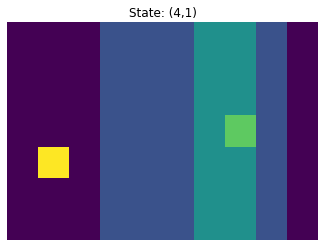

In [2]:
from envs import WindyGridWorld
from time import sleep
import numpy as np
from IPython.display import clear_output

%matplotlib inline
env = WindyGridWorld()

for i in range(10):
    a = np.random.choice([0,1,2,3])
    env.step(a)
    env.render()
    sleep(1)
    # clear_output(wait=True)

### Constructing an _online First-Visit Monte-Carlo_ Agent for the Windy Grid World

<img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/on-policy_MC_control_edited.PNG" width=800>

__As the training progresses, your agent should get less negative reward, and manages to finish the task sooner.__

# NOTE: Complete all the TODO sections

In [14]:
import numpy as np
np.random.seed(0)

class OnPolicy_FirstVisit_MC_Agent:
    def __init__(self, n_states, n_actions, epsilon=1, final_epsilon_value=0.001,
                 gamma=0.9, alpha=0.1, decay_factor=0.0002):
        self.epsilon = epsilon # ε is used for exploration, initially set to 1 for the maximum initial exploration
        self.final_epsilon_value = final_epsilon_value # The final value of the ε. Over time ε decays. 
        self.gamma = gamma # gamma is the discount factor, capturing the importance of future rewards for the agent
        self.alpha = alpha # The learning rate of the agent
        self.n_states = n_states # Number of states in the environment.
        self.n_actions = n_actions # Number of actions in the environment.
        self.decay_factor = decay_factor # The speed of decaying ε
        
        self.all_actions = np.arange(n_actions)
        self.Q = np.zeros(shape=(n_states, n_actions)) # Q(s,a) is a 2D numpy array representing agent's state-action value function.
        self.policy = self.init_epsilon_soft_policy(n_states, n_actions) # This is just for the sake of illustration
        
    ##### Redundant Code: Since we are not using the ε-soft policy. This's just an FYI.   
    def init_epsilon_soft_policy(self, n_states, n_actions):
        """
        The init_epsilon_soft_policy method initializes ε=1 which means the probability of each
        action is equal and uniformly distributed
        """
        policy = np.ones((n_states, n_actions), dtype=np.float32) / n_actions
        return policy

    def act_epsilon_soft(self, state):
        """
        The act method takes an action from the ε-soft policy
        """
        return np.random.choice(self.all_actions, p=self.policy[state, :])
    ################################
    
    def act(self, state, exploration=True):
        if exploration:
            if np.random.rand() < self.epsilon:
                action = np.random.choice(self.all_actions)
            else:
                action = action = np.argmax(self.Q[state, :])
        else: # Pure greedy, no exploration
            action = np.argmax(self.Q[state, :])
            
        return action
    
    def reset(self):
        self.states, self.actions, self.rewards = [], [], [0]  # Reward's index starts from 1
    
    def update(self, state, action, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        if done:
            self.epsilon_decay()
            G = 0
            visited = np.zeros((self.n_states, self.n_actions), dtype=np.int8)
            for t in reversed(range(len(self.states))):
                G = self.gamma * G + self.rewards[t+1] # Compute G using γ (gamma) and reward in t+1 timestep
                s, a = self.states[t], self.actions[t] # Saving s[t] and a[t] in s and a for easier access
                if visited[s, a] == 0:
                    visited[s, a] += 1
                else:
                    continue
                    
                self.Q[s, a] = self.Q[s, a] + self.alpha * (G - self.Q[s, a])
                A_optimal = np.argmax(self.Q[s, :])
                self.policy[s,:] = self.epsilon / self.n_actions
                self.policy[s, A_optimal] = 1 - self.epsilon + self.epsilon / self.n_actions
    
    def epsilon_decay(self):
        if self.epsilon > self.final_epsilon_value:
            self.epsilon -= self.decay_factor
        else:
            self.epsilon = self.final_epsilon_value

### Two Util Functions (Please Do not modify):
- display_status()
- play()

In [15]:
# Utils - PLEASE DO NOT MODIFY THIS CELL

def display_status(episode, return_episode, epsilon, stime, returns, avg_returns, policy):
    """
    A helper function for displaying agent's behavior
    """
    clear_output(wait=True)
    etime = time()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    axes[0].set_title("Episode:" + str(episode) + " - Return:"+str(return_episode)\
              + " - Epsilon:" + str(epsilon)[:5] + " - elapsed time: " + str(etime - stime)[:4])
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Returns (sum of rewards in each episode)")
    axes[0].plot(list(range(len(returns))),returns)
    axes[0].plot(list(range(len(returns))),avg_returns, linewidth=3)
    axes[0].legend(["Returns", "Average Returns"])

    axes[1].imshow((10 * policy).reshape(14, 20))
    axes[1].set_title("A representation of agent's policy")
    axes[1].legend(["0"])
    axes[1].axis("off")
    plt.show()
    
def play(env, agent, episodes=2, exploration=True, tolerance=20):
    for episode in range(episodes):
        env.reset()
        state = env.state
        done = False
        step = 0
        actions = []
        while not done:
            action = agent.act(state, exploration=exploration)
            new_state, reward, done, _ = env.step(action)
            step += 1
            state = new_state
            actions.append(action)
            clear_output(wait=True)
            env.render()
            if done:
                print(f"Done in {step} steps.")
                print(f"Actions: {actions}")
                for a in actions:
                    print(env.actions[a], end=", ")
                print()
                sleep(0.1)
            if step >= tolerance:
                print(f"No Done in {step} steps.")
                break
            sleep(0.1)

## Training an Agent:

### The initial performance of the agent before training

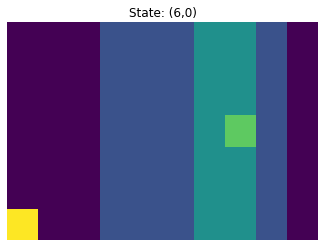

No Done in 20 steps.


In [5]:
env = WindyGridWorld()
agent = OnPolicy_FirstVisit_MC_Agent(n_states=env.states_n, n_actions=env.actions_n)

play(env, agent, episodes=1, tolerance=20)

### Training the Agent

### The Train Loop

<img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/MDP_loop.jpeg" width=800>

### The Training Process (~ Takes 1 minute)

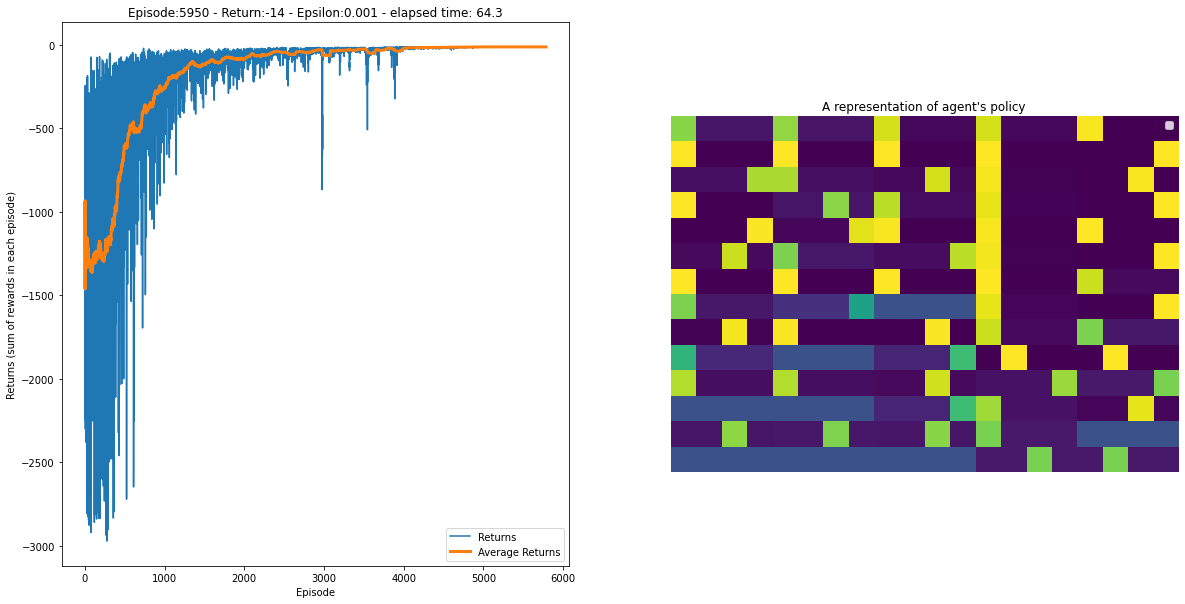

In [16]:
from envs import WindyGridWorld
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time

env = WindyGridWorld()
agent = OnPolicy_FirstVisit_MC_Agent(n_states=env.states_n, n_actions=env.actions_n) # , alpha=0.1, final_epsilon_value=0.001, decay_factor=0.0002)
EPISODES = 6000 # Training the agent for 6000 episodes
STEPS = 3000
DISPLAY_RESULTS_INTERVAL = 50

returns = []
avg_returns = []
stime = time()
for episode in range(EPISODES):
    state = env.reset()
    agent.reset()
    done = False
    
    return_episode = 0
    for step in range(STEPS):
        action = agent.act(state)
        state_, reward, done, info = env.step(action)
        agent.update(state, action ,reward, done)
        state = state_
        return_episode += reward
        if done:
            returns.append(return_episode)
            avg = (sum(returns[-100:]) / 100) if len(returns) > 100 else (sum(returns[-len(returns):]) / len(returns))
            avg_returns.append(avg)
            if episode % DISPLAY_RESULTS_INTERVAL == 0:
                display_status(episode, return_episode, agent.epsilon, stime, returns, avg_returns, agent.policy)
            break

## Watch a Smart Agent!

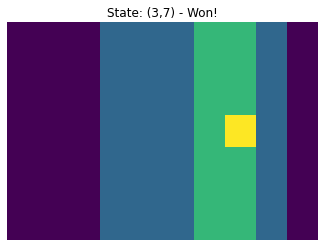

Done in 15 steps.
Actions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1]
right, right, right, right, right, right, right, right, right, down, down, down, down, left, left, 


In [17]:
# Change the value of "episodes" variable to a higher number if you want the agent to play more than 1 episode
play(env, agent, episodes=1, exploration=False)

a trained agent should find a path similar to the perdicted optimal policy. <br>
<img style="align: center;" src="https://github.com/FredAmouzgar/comp8220_ML_2021S1/raw/main/images/windygrid_actual.png" width=400>

## More Questions:

__Q1:__ What would happen if we turn the algorithm from one-visit to every-visit?

__Q2 (Programming):__ Use the Monte-Carlo algorithm to train an agent for the OpenAI Gym's environment.

__*Q3 (Programming):__ _Modify the Windy Gridworld and add King’s Moves_: Re-solve the windygridworld assuming eight possible actions, including the diagonal moves, rather than the usual four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind \[[Sutton2018](http://incompleteideas.net/book/the-book-2nd.html)\]?

__*Q4 (Programming):__ _Stochastic Wind_: Re-solve the windy gridworld task with King’s moves, assuming that the e↵ect of the wind, if there is any, is stochastic, sometimes varying by 1 from the mean values given for each column. That is, a third of the time you move exactly according to these values, as in the previous exercise, but also a third of the time you move one cell above that, and another third of the time you move one cell below that. For example, if you are one cell to the right of the goal and you move left, then one-third of the time you move one cell above the goal, one-third of the time you move two cells above the goal, and one-third of the time you move to the goal \[[Sutton2018](http://incompleteideas.net/book/the-book-2nd.html)\].

<font size="1px">* = harder questions</font>


<font size="1px"><a href="https://www.linkedin.com/in/fredamouzgar/">Fred A.</a> Mar/2021</font>